## Imports

In [1]:
%env LIBSUMO_AS_TRACI=1
!echo $LIBSUMO_AS_TRACI

env: LIBSUMO_AS_TRACI=1
1


In [2]:
from importlib import reload
import sys
import os

from typing import Any
from typing import Dict

current_dir = os.getcwd()

sys.path.append(os.path.join(current_dir, '..', '..'))

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Traffic Signal Controller Reinforcement Learning Modules

import tscRL.environments.environment
reload(tscRL.environments.environment)
from tscRL.environments.environment import SumoEnvironment, TrafficLight as tl
from tscRL.environments.rewardFn import *

import tscRL.agents.dqn_agent
reload(tscRL.agents.dqn_agent)
from tscRL.agents.ql_agent import QLAgent
from tscRL.agents.dqn_agent import DQNAgent
# Include sumo-tools directory
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
    


Using libsumo as traci as requested by environment variable.


In [3]:
sumoCfgFile_unbalanced = os.path.abspath(os.path.join(current_dir, '../../../nets/2x2_intersection/intersection_unbalanced.sumocfg'))

In [4]:
sumoCfgFile_unfair = os.path.abspath(os.path.join(current_dir, '../../../nets/2x2_intersection/intersection_WE.sumocfg'))

In [5]:
diff_cwt_rw = DiffCWaitingTime()

In [6]:
env = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unfair,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    encodeIntervals={"waitingTime":20,"halted":20},
    maxEncodeValue={"waitingTime":2500,"halted":30},
    laneInfos=["waitingTime","halted"],
    rewardFn=diff_cwt_rw,
    simTime=43800,
)


In [ ]:
from stable_baselines3.common.env_checker import check_env 
check_env(env)

In [11]:
dqn_agent = DQNAgent(
    env=env,
    learningRate=0.01,
    batchSize=64,
    explorationFraction=0.4,
    initialEpsilon = 0.8,
    verbose=1, 
    )

/home/juanma/Dev/tlc-rl/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [1]:
import torch
print(torch.cuda.is_available())  # Should print True if CUDA is available
print(torch.cuda.device_count())  

False
1


/home/juanma/Dev/tlc-rl/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
env.discreteClasses["halted"].get_max_encoded_value()

9

In [9]:
dqn_agent.learn(episodes=50)

----------------------------------------
| rollout/                 |           |
|    ep_len_mean           | 8.64e+03  |
|    ep_rew_mean           | -1.14e+03 |
|    exploration_rate      | 0.761     |
| time/                    |           |
|    episode_time          | 44.7      |
|    episodes              | 1         |
|    fps                   | 193       |
|    time_elapsed          | 44        |
|    total_timesteps       | 8641      |
| train/                   |           |
|    95p_acc_waiting_time  | 223       |
|    learning_rate         | 0.01      |
|    loss                  | 330       |
|    mean_acc_waiting_time | 82.6      |
|    n_updates             | 8640      |
----------------------------------------
----------------------------------------
| rollout/                 |           |
|    ep_len_mean           | 8.64e+03  |
|    ep_rew_mean           | -1.82e+03 |
|    exploration_rate      | 0.722     |
| time/                    |           |
|    episode_tim

In [10]:
env_2 = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unfair,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    encodeIntervals={"waitingTime":20,"halted":20},
    maxEncodeValue={"waitingTime":2500,"halted":30},
    laneInfos=["waitingTime","halted"],
    mainRewardFn="diff_cWaitingTime",
    fixedTL=False,
    simTime=43800,
    sumoLog = False
)


In [11]:
dqn_agent_2 = DQNAgent(
    env=env_2,
    learningRate=0.01,
    batchSize=64,
    explorationFraction=0.4,
    initialEpsilon = 0.8,
    verbose=1, 
    )

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
dqn_agent_2.learn(50)

In [13]:
df_dqn_f = pd.DataFrame(dqn_agent.callback.get_metrics())

In [14]:
df_dqn = pd.DataFrame(dqn_agent_2.callback.get_metrics())

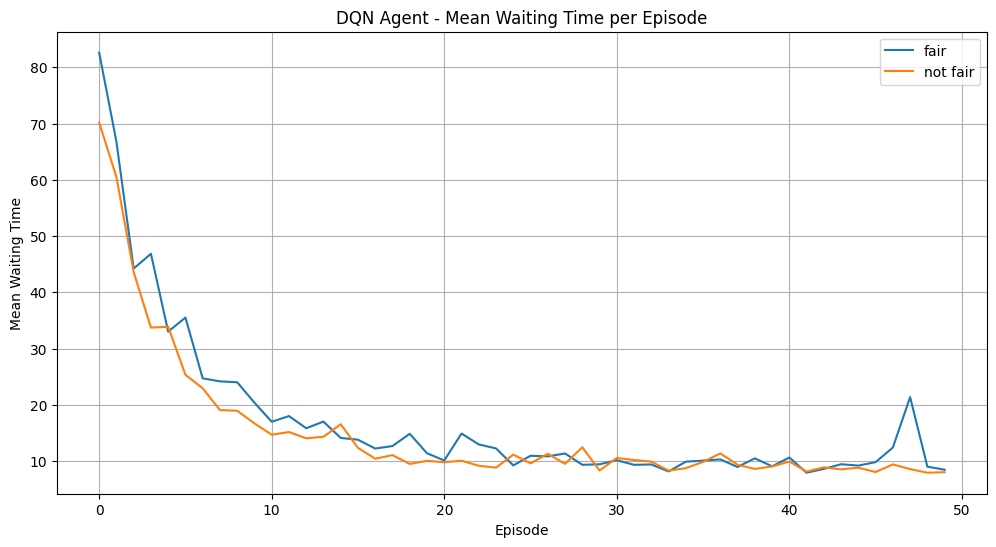

In [21]:
plt.figure(figsize=(12, 6))

plt.plot(df_dqn_f["episode"], df_dqn_f['mean_acc_waiting_time'],label="fair")
plt.plot(df_dqn["episode"], df_dqn['mean_acc_waiting_time'],label="not fair")

plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time')
plt.title('DQN Agent - Mean Waiting Time per Episode')
plt.legend()

plt.grid(True)
plt.show()

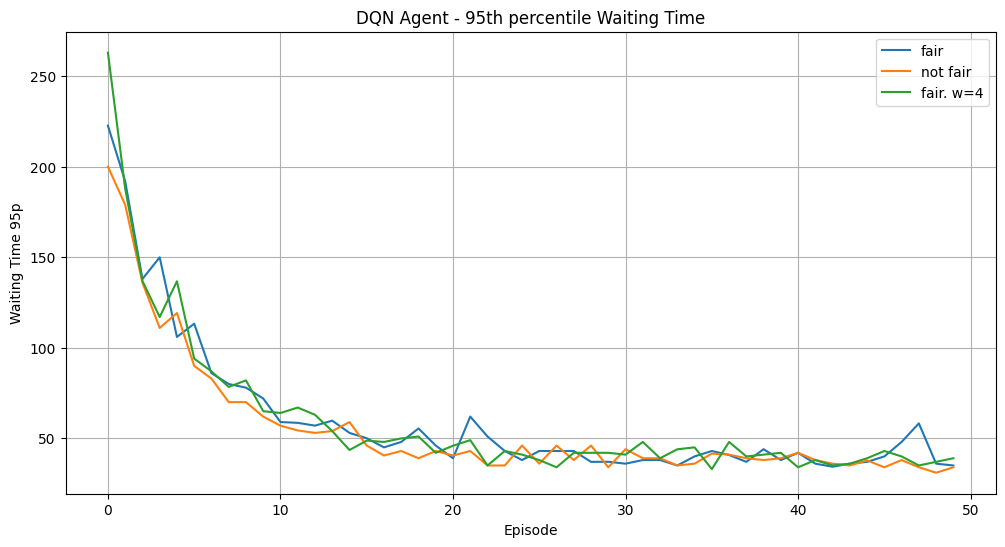

In [22]:
env_j4 = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unfair,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    encodeIntervals={"waitingTime":20,"halted":20},
    maxEncodeValue={"waitingTime":2500,"halted":30},
    laneInfos=["waitingTime","halted"],
    mainRewardFn="diff_cWaitingTime",
    fairRewardFn="diff_jain",
    fairRewardWeight=4,
    fixedTL=False,
    simTime=43800,
    sumoLog = False
)

In [23]:
dqn_agent_j4 = DQNAgent(
    env=env_j4,
    learningRate=0.01,
    batchSize=64,
    explorationFraction=0.4,
    initialEpsilon = 0.8,
    verbose=1, 
    )

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
dqn_agent_j4.learn(50)

In [25]:
df_dqn_j4 = pd.DataFrame(dqn_agent_j4.callback.get_metrics())

In [29]:
env_j20 = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unfair,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    encodeIntervals={"waitingTime":20,"halted":20},
    maxEncodeValue={"waitingTime":2500,"halted":30},
    laneInfos=["waitingTime","halted"],
    mainRewardFn="diff_cWaitingTime",
    fairRewardFn="diff_jain",
    fairRewardWeight=20,
    fixedTL=False,
    simTime=43800,
    sumoLog = False
)

dqn_agent_j20 = DQNAgent(
    env=env_j20,
    learningRate=0.01,
    batchSize=64,
    explorationFraction=0.4,
    initialEpsilon = 0.8,
    verbose=1, 
    )
dqn_agent_j20.learn(50)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loading state from '/home/juanma/Dev/tlc-rl/code/tscRL/.states/initialState.xml' ...----------------------------------------
| rollout/                 |           |
|    ep_len_mean           | 8.64e+03  |
|    ep_rew_mean           | -1.28e+03 |
|    exploration_rate      | 0.761     |
| time/                    |           |
|    episode_time          | 46.2      |
|    episodes              | 1         |
|    fps                   | 187       |
|    time_elapsed          | 46        |
|    total_timesteps       | 8641      |
| train/                   |           |
|    95p_acc_waiting_time  | 229       |
|    learning_rate         | 0.01      |
|    loss                  | 365       |
|    mean_acc_waiting_time | 86.5      |
|    n_updates             | 8640      |
----------------------------------------
----------------------------------------
| rollout/                 |           |
|

In [31]:
df_dqn_j20 = pd.DataFrame(dqn_agent_j20.callback.get_metrics())

In [35]:
env_j10 = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unfair,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    encodeIntervals={"waitingTime":20,"halted":20},
    maxEncodeValue={"waitingTime":2500,"halted":30},
    laneInfos=["waitingTime","halted"],
    mainRewardFn="diff_cWaitingTime",
    fairRewardFn="diff_jain",
    fairRewardWeight=10,
    fixedTL=False,
    simTime=43800,
    sumoLog = False
)

dqn_agent_j10 = DQNAgent(
    env=env_j10,
    learningRate=0.01,
    batchSize=64,
    explorationFraction=0.4,
    initialEpsilon = 0.8,
    verbose=1, 
    )
dqn_agent_j10.learn(50)
df_dqn_j10 = pd.DataFrame(dqn_agent_j10.callback.get_metrics())

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------------
| rollout/                 |          |
|    ep_len_mean           | 8.64e+03 |
|    ep_rew_mean           | -2.6e+03 |
|    exploration_rate      | 0.761    |
| time/                    |          |
|    episode_time          | 44.4     |
|    episodes              | 1        |
|    fps                   | 194      |
|    time_elapsed          | 44       |
|    total_timesteps       | 8641     |
| train/                   |          |
|    95p_acc_waiting_time  | 195      |
|    learning_rate         | 0.01     |
|    loss                  | 190      |
|    mean_acc_waiting_time | 66.1     |
|    n_updates             | 8640     |
---------------------------------------
----------------------------------------
| rollout/                 |           |
|    ep_len_mean           | 8.64e+03  |
|    ep_rew_mean           | -1.65e+03 |
|    exploration_rate

In [43]:
df_dqn.to_csv('df_WE_not_fair.csv', index=False)

In [44]:
df_dqn_f.to_csv('df_WE_fair_w2.csv', index=False)

In [45]:
df_dqn_j4.to_csv('df_WE_fair_w4.csv', index=False)

In [46]:
df_dqn_j10.to_csv('df_WE_fair_w10.csv', index=False)

In [47]:
df_dqn_j20.to_csv('df_WE_fair_w20.csv', index=False)

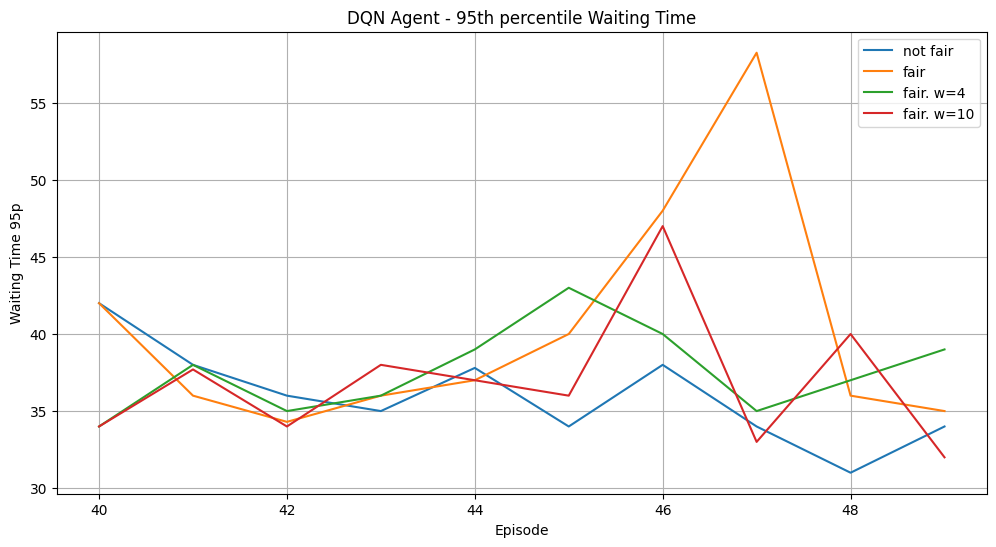

In [40]:
plt.figure(figsize=(12, 6))


plt.plot(df_dqn.tail(10)["episode"], df_dqn.tail(10)['waiting_time_95p'],label="not fair")
plt.plot(df_dqn_f.tail(10)["episode"], df_dqn_f.tail(10)['waiting_time_95p'],label="fair")
plt.plot(df_dqn_j4.tail(10)["episode"], df_dqn_j4.tail(10)['waiting_time_95p'],label="fair. w=4")
plt.plot(df_dqn_j10.tail(10)["episode"], df_dqn_j10.tail(10)['waiting_time_95p'],label="fair. w=10")
#plt.plot(df_dqn_j20["episode"], df_dqn_j20['waiting_time_95p'],label="fair. w=20")



plt.xlabel('Episode')
plt.ylabel('Waiting Time 95p')
plt.title('DQN Agent - 95th percentile Waiting Time')
plt.legend()

plt.grid(True)
plt.show()

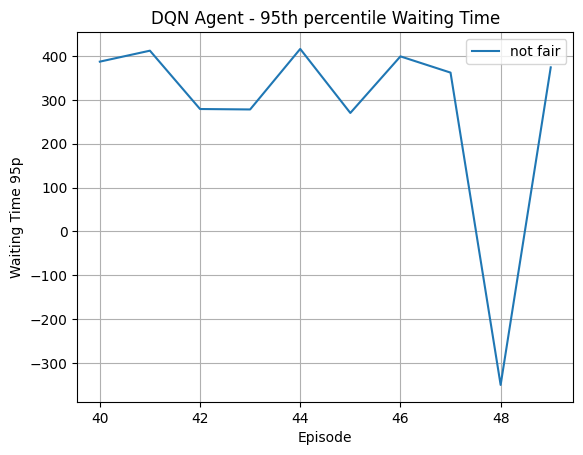

In [42]:


plt.plot(df_dqn.tail(10)["episode"], df_dqn.tail(10)['cumulative_reward'],label="not fair")

#plt.plot(df_dqn_j20["episode"], df_dqn_j20['waiting_time_95p'],label="fair. w=20")



plt.xlabel('Episode')
plt.ylabel('Waiting Time 95p')
plt.title('DQN Agent - 95th percentile Waiting Time')
plt.legend()

plt.grid(True)
plt.show()

In [28]:
env.discreteClasses["waitingTime"].get_max_encoded_value()

7845.0

## Hyperparameter Tuning

In [ ]:
import optuna
reload(optuna)
from optuna.pruners import MedianPruner
from optuna.samplers import RandomSampler

from tscRL.agents.callbacks import TrialCallback

import gymnasium as gym
import torch
from stable_baselines3.common.monitor import Monitor

In [ ]:
from tscRL.agents import callbacks
reload(callbacks)

In [ ]:
DEFAULT_HYPERPARAMS = {
    "env": env
}

In [ ]:
def sample_dqn_params(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    buffer_size = trial.suggest_categorical("buffer_size", [100000, 500000, 1000000])
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.6)
    target_update_interval = trial.suggest_categorical("target_update_interval", [1000, 5000, 10000])
    layer_size = trial.suggest_categorical("layer", [32, 64, 128])
    net_arch = (layer_size, layer_size)

    hyperparams = {
        "learningRate": learning_rate,
        "batchSize": batch_size,
        "bufferSize": buffer_size,
        "explorationFraction": exploration_fraction,
        "targetUpdateInterval": target_update_interval,
        "netArch": net_arch
    }

    return hyperparams

In [ ]:
N_EVAL_EPISODES = 50


In [ ]:
def objective(trial: optuna.Trial):
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_dqn_params(trial))
    kwargs["callback"] = TrialCallback(trial=trial, n_eval_episodes=N_EVAL_EPISODES, min_trial_fract=0.75, rewards_window_size=6, prune=False )

    dqn_agent = DQNAgent(**kwargs)
    
    nan_encountered = False
    try:
        dqn_agent.learn(episodes=N_EVAL_EPISODES)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    if dqn_agent.callback.is_pruned:
        raise optuna.exceptions.TrialPruned()
    last_crs = dqn_agent.callback.last_cumulative_rewards
    return np.mean(last_crs)

In [ ]:
N_TRIALS=5

In [ ]:
pruner = MedianPruner()

study = optuna.create_study(pruner=pruner, direction="maximize")

try:
    study.optimize(objective, n_trials=N_TRIALS)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study2)

In [ ]:
def sample_dqn_params2(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """

    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    buffer_size = trial.suggest_categorical("buffer_size", [100000, 500000, 1000000])
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.6)
    target_update_interval = trial.suggest_categorical("target_update_interval", [1000, 5000, 10000])
    layer_size = trial.suggest_categorical("layer", [32, 64, 128])
    net_arch = (layer_size, layer_size)

    hyperparams = {
        "batchSize": batch_size,
        "bufferSize": buffer_size,
        "explorationFraction": exploration_fraction,
        "targetUpdateInterval": target_update_interval,
        "netArch": net_arch
    }

    return hyperparams

In [ ]:
def objective2(trial: optuna.Trial):
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_dqn_params2(trial))
    kwargs["learningRate"] = 0.01
    kwargs["callback"] = TrialCallback(trial=trial, n_eval_episodes=N_EVAL_EPISODES, min_trial_fract=0.75, rewards_window_size=6, prune=False )

    dqn_agent = DQNAgent(**kwargs)
    
    nan_encountered = False
    try:
        dqn_agent.learn(episodes=N_EVAL_EPISODES)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    if dqn_agent.callback.is_pruned:
        raise optuna.exceptions.TrialPruned()
    last_crs = dqn_agent.callback.last_cumulative_rewards
    return np.mean(last_crs)

In [ ]:
study2 = optuna.create_study(pruner=pruner, direction="maximize")

try:
    study2.optimize(objective2, n_trials=5)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study2.trials))

print("Best trial:")
trial = study2.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
#%store study2

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study2)

In [ ]:
try:
    study2.optimize(objective2, n_trials=5)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study2.trials))

print("Best trial:")
trial = study2.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
fig = optuna.visualization.plot_param_importances(study2)
fig.show()

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

In [ ]:
for i in [1,2,3,4,5,6,12]:
    print("Trial " + str(i) + ". Value= " + str(study.trials[i].value)  + ". Params: ", end="")
    print(study.trials[i].params)

In [ ]:
for i in [0,7,8,9,10,11]:
    print("Trial " + str(i) + ". Value= " + str(study.trials[i].value)  + ". Params: ", end="")
    print(study.trials[i].params)

Se puede observar como un exploration_fraction bajo produce una divergencia de la solución

In [ ]:
def sample_dqn_params3(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """

    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    buffer_size = trial.suggest_categorical("buffer_size", [500000, 1000000])
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.4, 0.75)
    target_update_interval = trial.suggest_categorical("target_update_interval", [1000, 5000, 10000])
    layer_size = trial.suggest_categorical("layer", [32, 64,128])
    net_arch = (layer_size, layer_size)

    hyperparams = {
        "batchSize": batch_size,
        "bufferSize": buffer_size,
        "explorationFraction": exploration_fraction,
        "targetUpdateInterval": target_update_interval,
        "netArch": net_arch
    }

    return hyperparams

In [ ]:
def objective3(trial: optuna.Trial):
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_dqn_params3(trial))
    kwargs["learningRate"] = 0.01
    kwargs["callback"] = TrialCallback(trial=trial, n_eval_episodes=N_EVAL_EPISODES, min_trial_fract=0.9, rewards_window_size=6, prune=False, verbose=True)

    dqn_agent = DQNAgent(**kwargs)
    
    nan_encountered = False
    try:
        dqn_agent.learn(episodes=N_EVAL_EPISODES)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    if dqn_agent.callback.is_pruned:
        raise optuna.exceptions.TrialPruned()
    last_crs = dqn_agent.callback.last_cumulative_rewards
    return np.mean(last_crs)

In [ ]:
pruner = MedianPruner()
if "study3" not in globals():
    study3 = optuna.create_study(pruner=pruner, direction="maximize")
try:
    study3.optimize(objective3, n_trials=5)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study3.trials))

print("Best trial:")
trial = study3.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
#%store study3

In [ ]:
%store -r

In [ ]:
try:
    study3.optimize(objective3, n_trials=5)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study3.trials))

print("Best trial:")
trial = study3.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
fig = optuna.visualization.plot_param_importances(study3)
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(study3, params=["layer", "target_update_interval", "exploration_fraction"])
fig.show()



In [ ]:
for i in [1,8,16]:
    print("Trial " + str(i) + ". Value= " + str(study3.trials[i].value)  + ". Params: ", end="")
    print(study3.trials[i].params)

In [ ]:
for i in [0,2,3,4,7,9,10,11,12,13,14,15]:
    print("Trial " + str(i) + ". Value= " + str(study3.trials[i].value)  + ". Params: ", end="")
    print(study3.trials[i].params)

In [ ]:
df_study = study.trials_dataframe()
df_study.to_csv('parametersStudy.csv', index=False)

In [ ]:
df_study3 = study3.trials_dataframe()
df_study3.to_csv('parametersStudy3.csv', index=False)

In [ ]:
def sample_dqn_params4(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    buffer_size = trial.suggest_categorical("buffer_size", [500000, 1000000])

    hyperparams = {
        "learningRate": learning_rate,
        "batchSize": batch_size,
        "bufferSize": buffer_size
    }

    return hyperparams

In [ ]:
N_EVAL_EPISODES_2 = 75

In [ ]:
def objective4(trial: optuna.Trial):
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_dqn_params4(trial))
    kwargs["explorationFraction"] = 0.5
    kwargs["targetUpdateInterval"] = 1000
    kwargs["netArch"] = (32, 32)
    kwargs["callback"] = TrialCallback(trial=trial, n_eval_episodes=N_EVAL_EPISODES_2, min_trial_fract=0.9, rewards_window_size=10, prune=False, verbose=True)

    dqn_agent = DQNAgent(**kwargs)
    
    nan_encountered = False
    try:
        dqn_agent.learn(episodes=N_EVAL_EPISODES_2)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    if dqn_agent.callback.is_pruned:
        raise optuna.exceptions.TrialPruned()
    last_crs = dqn_agent.callback.last_cumulative_rewards
    return np.mean(last_crs)

In [ ]:
pruner = MedianPruner()

study4 = optuna.create_study(pruner=pruner, direction="maximize")
for _ in range(5):
    study4.optimize(objective4, n_trials=1)
    %store study4


print("Number of finished trials: ", len(study4.trials))

print("Best trial:")
trial = study4.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
for _ in range(5):
    study4.optimize(objective4, n_trials=1)
    %store study4


print("Number of finished trials: ", len(study4.trials))

print("Best trial:")
trial = study4.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
df_study4 = study4.trials_dataframe()
df_study4.to_csv('parametersStudy4.csv', index=False)

In [ ]:
fig = optuna.visualization.plot_param_importances(study4)
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(study4)
fig.show()

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study4)
fig.show()


In [ ]:
env = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unbalanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=False,
    simTime=43800, 
    sumoLog=False
)

In [ ]:
dqn_agent = DQNAgent(
    env=env,
    learningRate=0.001,
    batchSize=64,
    explorationFraction=0.5,
    verbose=1)

In [ ]:
print(dqn_agent.model.get_env())

In [ ]:
MODEL_ID = "dqn_unbalanced"

In [ ]:
dqn_agent.learn(100)
dqn_agent.model.save(MODEL_ID)

In [ ]:
env = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unbalanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=True,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=False,
    simTime=43800, 
    sumoLog=False
)

In [ ]:
dqn_agent_ = DQNAgent(
    env=env,
    learningRate=0.001,
    batchSize=64,
    explorationFraction=0.5,
    verbose=1)

In [ ]:
modelFileLocation = os.path.join(os.getcwd(), MODEL_ID)
modelFileLocation

In [ ]:
env.close()

In [ ]:
dqn_agent_.loadModel(modelFileLocation, env)


In [ ]:
dqn_agent_.run()

In [ ]:
metrics_dqn_unbalanced = dqn_agent.callback.get_metrics()
df_dqn_unbalanced = pd.DataFrame(metrics_dqn_unbalanced)
df_dqn_unbalanced.to_csv('df_dqn_unbalanced.csv', index=False) 


In [ ]:
def serializeRuns(runs, fileName):
    rows = []
    # Iterar sobre la lista de diccionarios
    for run, entry in enumerate(runs):
        for episode, mwt, mawt, cr, t in zip(entry["episode"], entry["mean_waiting_time"], entry["mean_acc_waiting_time"], entry["cumulative_reward"], entry["time"]):
            rows.append({"run": run, "episode": episode, "mean_waiting_time": mwt, "mean_acc_waiting_time": mawt, "cumulative_reward": cr, "time": t})

    # Crear el DataFrame
    df = pd.DataFrame(rows)
    df.to_csv(fileName, index=False)
    return df


In [ ]:
df_balanced_unb_ftl = pd.read_csv("df_unbalanced_ftl.csv")
df_dqn_unbalanced = pd.read_csv("df_dqn_unbalanced.csv")

In [ ]:
print("Mean cumulative waiting time in fixed TLC: " + str(df_balanced_unb_ftl["mean_acc_waiting_time"].mean()))
print("Mean cumulative waiting time in final trained DQNTLC: " + str(df_dqn_unbalanced.loc[df_dqn_unbalanced['episode'] == 100, 'mean_acc_waiting_time'].values[0]))

In [ ]:

plt.figure(figsize=(12, 8))

plt.plot(df_dqn_unbalanced["episode"], df_dqn_unbalanced['mean_acc_waiting_time'], label="DQN Agent")

plt.plot(df_balanced_unb_ftl["episode"], df_balanced_unb_ftl['mean_acc_waiting_time'], label="Fixed TL")

plt.xlabel('Episode', fontsize=20)
plt.ylabel('Mean Waiting Time (in seconds)')
plt.title('DQN Agent - Mean Accumulated Waiting Time per Episode')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_dqn_unbalanced["episode"], df_dqn_unbalanced['cumulative_reward'])

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN Agent - Cumulative Reward per Episode')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_dqn_unbalanced["episode"], df_dqn_unbalanced['loss_value'])

plt.xlabel('Episode')
plt.ylabel('Loss value')
plt.title('DQN Agent - Loss per Episode')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sumoCfgFile_balanced = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/intersection_balanced.sumocfg'))

In [ ]:
env_balanced = SumoEnvironment(
    sumocfgFile=sumoCfgFile_balanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=False,
    simTime=43800, 
    sumoLog=False
)

In [ ]:
dqn_agent = DQNAgent(
    env=env_balanced,
    learningRate=0.001,
    batchSize=64,
    explorationFraction=0.5,
    verbose=1
)
dqn_agent.learn(episodes=100)
metrics = dqn_agent.callback.get_metrics()

In [ ]:
df_balanced = pd.DataFrame(metrics)
df_balanced.to_csv("dqn_agent_balanced", index=False)

In [ ]:

from tscRL.agents import fixedTL_agent as ftl_agent

In [ ]:
ftl_agent.FixedTLAgent

In [ ]:
sumoCfgFile_balanced = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/intersection_balanced.sumocfg'))

In [ ]:
env_unbalanced_ftl = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unbalanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=True,
    simTime=43800, 
    sumoLog=False
)

In [ ]:
env_balanced_ftl = SumoEnvironment(
    sumocfgFile=sumoCfgFile_balanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=True,
    simTime=43800, 
    sumoLog=False
)

In [ ]:
ftlAgent = ftl_agent.FixedTLAgent(environment=env_unbalanced_ftl, episodes=100)
metrics_unb_ftl = ftlAgent.run()

In [ ]:
ftlAgent = ftl_agent.FixedTLAgent(environment=env_balanced_ftl, episodes=100)
metrics_bal_ftl = ftlAgent.run()

In [ ]:
df_unbalanced_ftl = pd.DataFrame(metrics_unb_ftl)
df_unbalanced_ftl.to_csv('df_unbalanced_ftl.csv', index=False)

In [ ]:
float(df_balanced_ftl["mean_acc_waiting_time"].mean())

In [ ]:
float(df_unbalanced_ftl["mean_acc_waiting_time"].mean())

In [ ]:
float(df_balanced_ftl["mean_acc_waiting_time"].mean())

In [ ]:
df_unbalanced_ftl=pd.read_csv("df_unbalanced_ftl.csv")
df_balanced_ftl=pd.read_csv("df_balanced_ftl.csv")

In [ ]:
df_balanced_ftl = pd.DataFrame(metrics_bal_ftl)
df_balanced_ftl.to_csv('df_balanced_ftl.csv', index=False)

In [ ]:
df_balanced_ftl["mean_acc_waiting_time"].mean()

In [ ]:
df_dqn_balanced[df_dqn_balanced['episode'] == 99]["mean_acc_waiting_time"]

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_dqn_balanced["episode"], df_dqn_balanced['mean_acc_waiting_time'], label="DQN Agent")
plt.plot(df_balanced_ftl["episode"], df_balanced_ftl['mean_acc_waiting_time'], label="Fixed TL")
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time (in seconds)')
plt.title('DQN Agent - Mean Accumulated Waiting Time per Episode')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_balanced["episode"], df_balanced['cumulative_reward'])

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN Agent - Cumulative Reward per Episode')
plt.legend()
plt.grid(True)
plt.show()